In [1]:
import tensorflow as tf 

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import PIL
import time
import glob
import imageio

In [2]:
'''
    FIX:
        Mode collapse is still a huge problem here. Using MSE as the loss function makes it happen less often, but
        makes the quality of the generated samples not as crisp as Binary Crossentropy
'''

'\n    FIX:\n        Mode collapse is still a huge problem here. Using MSE as the loss function makes it happen less often, but\n        makes the quality of the generated samples not as crisp as Binary Crossentropy\n'

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)

In [4]:
# Batch and shuffle the data
EPOCHS = 50
BUFFER_SIZE = 60000
BATCH_SIZE = 64
noise_dim = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [5]:
def build_gen_model():
    model = tf.keras.Sequential([
                               tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim, )),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Reshape((7, 7, 256)),

                               tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
    assert model.output_shape == (None, 28, 28, 1)
    return model

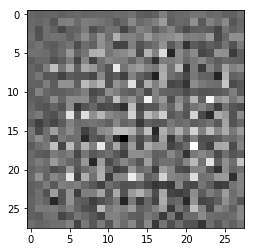

In [6]:
gen = build_gen_model()

im = gen(tf.random.normal([1,noise_dim]), training=False)
plt.imshow(np.squeeze(im), cmap='gray')

In [7]:
def build_disc_model():
    model = tf.keras.Sequential([
                               tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape = (28, 28, 1)),
                               tf.keras.layers.LeakyReLU(),
                               tf.keras.layers.Dropout(0.3),

                               tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                               tf.keras.layers.LeakyReLU(),
                               tf.keras.layers.Dropout(0.3),

                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

                               ])
    return model

In [8]:
disc = build_disc_model()
print(np.squeeze(disc(im, training=False)))


0.49949422


In [9]:
#loss = tf.keras.losses.binary_crossentropy
loss = tf.keras.losses.mse

def discriminator_loss(real_output, fake_output):
    real_loss = loss(real_output, tf.ones_like(real_output))
    fake_loss = loss(fake_output, tf.zeros_like(fake_output))
    return fake_loss + real_loss

def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)


In [10]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    filename = 'image_at_epoch_'+str(epoch)+'.png'
    #plt.savefig(filename)
    plt.show()

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([len(images), noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)

        real_output = disc(images, training=True)
        fake_output = disc(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gen_gradient = gen_tape.gradient(gen_loss, gen.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, disc.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradient, gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradient, disc.trainable_variables))


In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(gen,
                                 epoch + 1,
                                 seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(gen,
                           epochs,
                           seed)




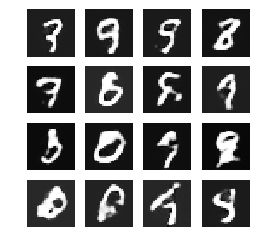

In [15]:
train(train_dataset, EPOCHS)

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_'+str(epoch_no)+'.png')

In [ ]:
display_image(1)